# Mean Diffusivity Results

In [2]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat

sys.path.append(os.path.abspath('../../Code/Software/CarDpy-master'))
from cardpy.Sample_Data.Data_Paths import *
from cardpy.Data_Import            import *
from cardpy.Data_Sorting           import *
from cardpy.Data_Processing.DTI    import *
from cardpy.GUI_Tools              import IntERCOMS
from cardpy.Colormaps              import *
from cardpy.Data_Saving            import *
from cardpy.Data_Processing.cDTI   import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import nrrd

cDTI_cmaps     = cDTI_Colormaps_Generator()



import seaborn as sns
sns.set(style='darkgrid', palette='Set2')



# Data Loading
In these steps we load the data and compute the population median from the means of each volunteer


In [3]:
vox_folder = ['vol_2.0res_3.0sl','vol_2.0res_5.0sl','vol_2.0res_8.0sl',
            'vol_2.5res_3.0sl','vol_2.5res_5.0sl','vol_2.5res_8.0sl',
            'vol_3.0res_3.5sl','vol_3.0res_5.5sl','vol_3.0res_8.0sl']
            
vol_idx = ['V001','V002','V003','V004','V005','V006','V007','V008','V009','V010', 'V011']
volumes = [2*2*3,2*2*5,2*2*8,2.5*2.5*3,2.5*2.5*5,2.5*2.5*8,3*3*3.5,3*3*5.5,3*3*8]

In [22]:
# Load in Volunteer Data
tot_volunteers = 11

# Initialize empty dataframes for median. This list will be converted to the dataframe
MD =np.zeros((tot_volunteers,9))
median = pd.DataFrame({})
df = pd.DataFrame({})


for vv in range(0,tot_volunteers):

    for ii in range(9):
        main_path = os.path.join(os.path.abspath('../../Data/NifTi/'+vol_idx[vv]) + '/'+ vox_folder[ii] + '/ADC_Filtered')
        path_segmentation = os.path.join(os.path.abspath('../../Data/Segmentations/'+vol_idx[vv]),vox_folder[ii])
        path_maps  = os.path.join(os.path.abspath('../../Data/DTI_Maps/'+vol_idx[vv])+'/'+ vox_folder[ii] + '/ADC_Filtered')

        NifTi_path = glob.glob(os.path.join(main_path, '*Averaged', '*.nii'))[0]
        header_path              = glob.glob(os.path.join(main_path, '*Averaged', '*.header'))[0]
        b_values_path            = glob.glob(os.path.join(main_path, '*Averaged', '*.bvals'))[0]
        b_vectors_path           = glob.glob(os.path.join(main_path, '*Averaged', '*.bvecs'))[0]


        Seg_path    = os.path.join(path_segmentation)
        Maps_Folder = os.path.join(path_maps)

        
        [data, b_vals_stacked, b_vecs_stacked, Header, _, _] = NifTi_Reader(NifTi_path, b_values_path, b_vectors_path, header_path)
        myo_mask = loadmat(os.path.join(Seg_path,'Interpolated_mask.mat'))['Mask']
        myo_mask = myo_mask.astype('float')
        myo_mask[myo_mask == 0] = np.nan

        dim_x = data.shape[0]
        dim_y = data.shape[1]

        Standard_DTI_Metrics = loadmat(os.path.join(Maps_Folder, 'Standard_DTI_Metrics.mat'))
        # MD
        MD[vv,ii] = np.nanmean(np.squeeze(Standard_DTI_Metrics['MD']*myo_mask),axis = (0,1))


        md_array = np.reshape(np.squeeze(Standard_DTI_Metrics['MD']*myo_mask),(dim_x*dim_y))

        
        voxel = np.repeat(volumes[ii],dim_x*dim_y)
        volunteer = np.repeat(vol_idx[ii],dim_x*dim_y)
        res = np.repeat(vox_folder[ii],dim_x*dim_y)
        inplane  = np.repeat(vox_folder[ii].split('_')[1],dim_x*dim_y)
        df = df.append(pd.DataFrame({'MD':md_array,'Voxel':voxel,'Inplane':inplane,
                'Volunteer':volunteer,'Resolution':res}),ignore_index=True)
        

      
        median = median.append(pd.DataFrame({'MD':np.nanmedian(np.squeeze(Standard_DTI_Metrics['MD']*myo_mask),axis = (0,1)),
                'Voxel':float(volumes[ii]),'Inplane':vox_folder[ii].split('_')[1],
                'Volunteer':[vol_idx[ii]],'Resolution':vox_folder[ii]}),ignore_index=True)
        

        
med_MD = np.nanmedian(MD,axis = 0)
med_MD.shape

<ipython-input-22-d22ad0c423d6>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'MD':md_array,'Voxel':voxel,'Inplane':inplane,
<ipython-input-22-d22ad0c423d6>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  median = median.append(pd.DataFrame({'MD':np.nanmedian(np.squeeze(Standard_DTI_Metrics['MD']*myo_mask),axis = (0,1)),
<ipython-input-22-d22ad0c423d6>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'MD':md_array,'Voxel':voxel,'Inplane':inplane,
<ipython-input-22-d22ad0c423d6>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  median = median.append(pd.DataFrame({'MD':np.n

(9,)

In [23]:
# Defining the lower and upper bound for each voxel 
lb_idx = int(0.025*11)
ub_idx = int(0.975*11)
sorted_MD = np.sort(MD,axis = 0)
lb = sorted_MD[lb_idx,:]
ub = sorted_MD[ub_idx,:]

# Summary of Example Images (Figure 2A)
This section loads in a volunteer and shows all of the example maps for that Volunteer. In the manuscript volunter vv=8 was used. 

- Cube Like = 2x2x3,2.5x2.5x3, 3x3x3.5 mm3
- Brick Like = 2x2x5,2.5x2.5x5, 3x3x5.5 mm3
- Pencil Like = 2x2x8,2.5x2.5x8, 3x3x8 mm3

In [24]:
# Choose a Volunteer to load: 
vv = 8

In [25]:
ims = []
maps = []
for ii in range(9):
    main_path = os.path.join(os.path.abspath('../../Data/NifTi/'+vol_idx[vv]) + '/'+ vox_folder[ii] + '/ADC_Filtered')
    path_segmentation = os.path.join(os.path.abspath('../../Data/Segmentations/'+vol_idx[vv]),vox_folder[ii])
    path_maps  = os.path.join(os.path.abspath('../../Data/DTI_Maps/'+vol_idx[vv])+'/'+ vox_folder[ii] + '/ADC_Filtered')

    NifTi_path = glob.glob(os.path.join(main_path, '*Averaged', '*.nii'))[0]
    header_path              = glob.glob(os.path.join(main_path, '*Averaged', '*.header'))[0]
    b_values_path            = glob.glob(os.path.join(main_path, '*Averaged', '*.bvals'))[0]
    b_vectors_path           = glob.glob(os.path.join(main_path, '*Averaged', '*.bvecs'))[0]


    Seg_path    = os.path.join(path_segmentation)
    Maps_Folder = os.path.join(path_maps)

    
    [data, b_vals_stacked, b_vecs_stacked, Header, _, _] = NifTi_Reader(NifTi_path, b_values_path, b_vectors_path, header_path)
    ims.append(data)

    myo_mask = loadmat(os.path.join(Seg_path,'Interpolated_mask.mat'))['Mask']
    myo_mask = myo_mask.astype('float')
    myo_mask[myo_mask == 0] = np.nan

    Standard_DTI_Metrics = loadmat(os.path.join(Maps_Folder, 'Standard_DTI_Metrics.mat'))
    maps.append(Standard_DTI_Metrics['MD']*myo_mask) 

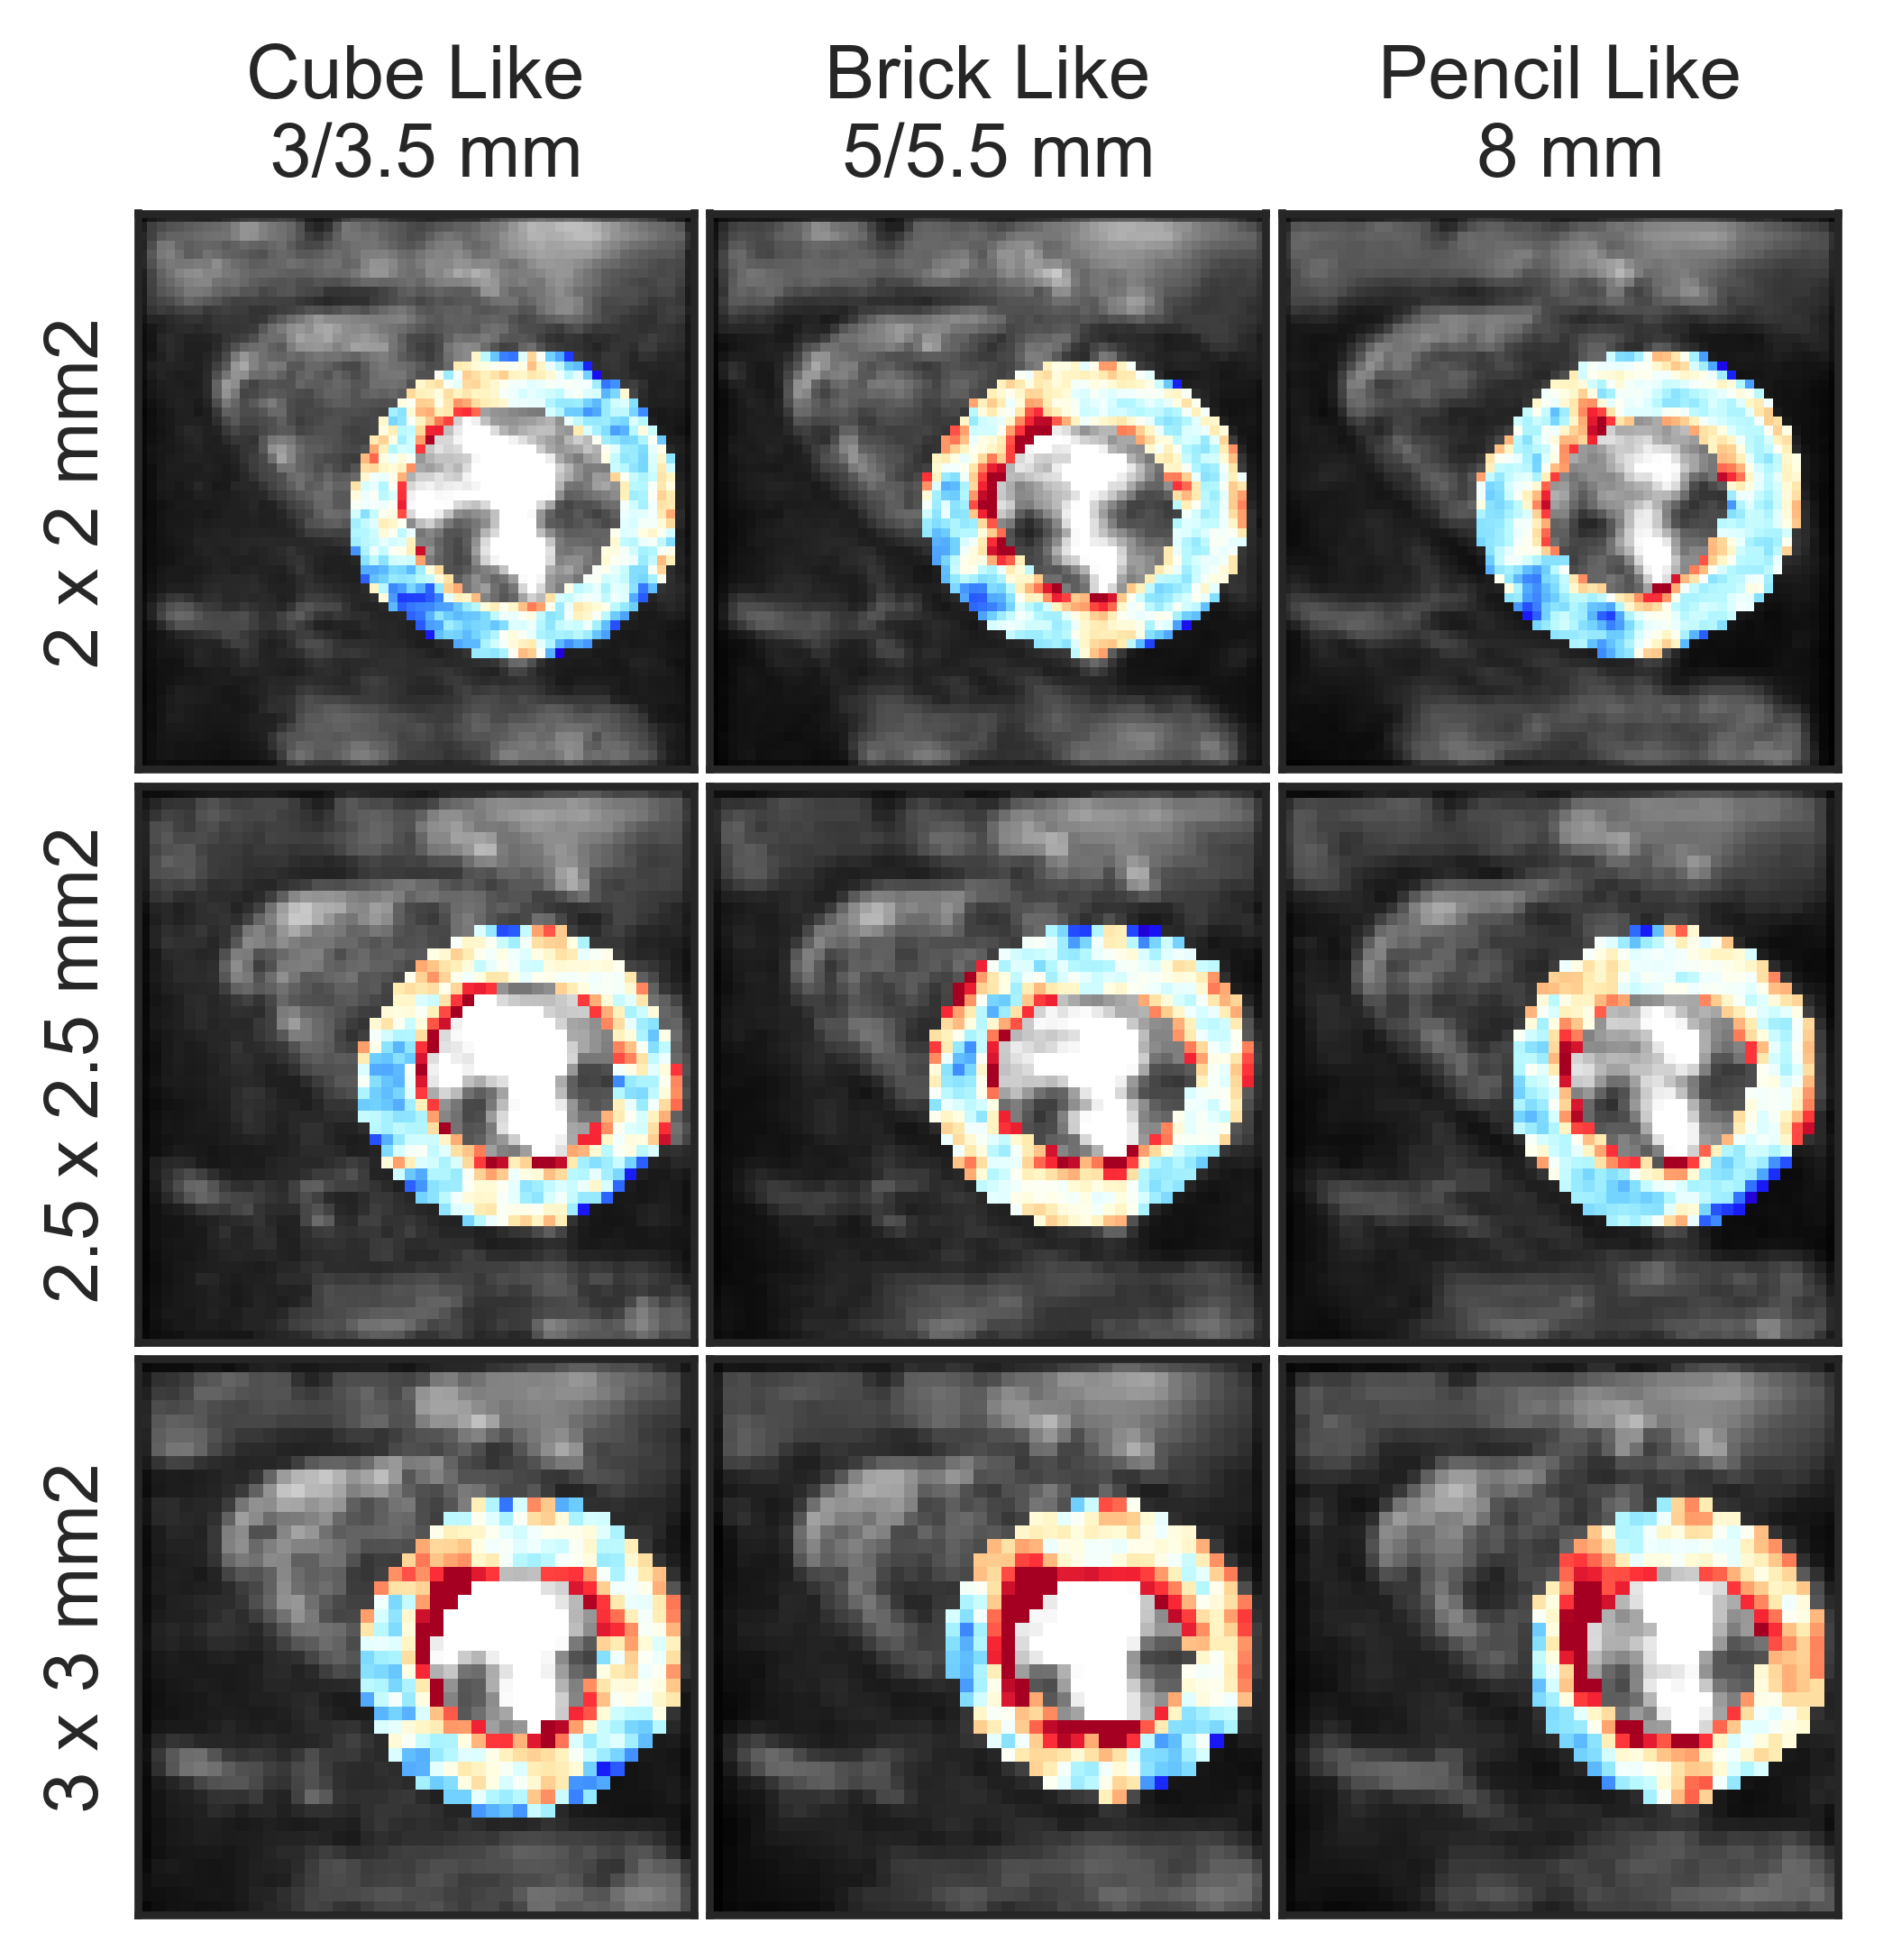

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(5,5),dpi=500)

count = 0
for ii in range(3):
    for jj in range(3):
        ax = axes[ii,jj]
        ax.imshow(ims[count][:,:,0,0],cmap = 'gray',vmin = 0,vmax = 120)
        ax.imshow(maps[count][:,:,0],cmap = cDTI_cmaps['MD'],vmin = 0,vmax = 3)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.grid(False)

        count +=1
        
plt.subplots_adjust(wspace=-0.05, hspace=0.03)

axes[0,0].set_title('Cube Like\n 3/3.5 mm')
axes[0,1].set_title('Brick Like\n 5/5.5 mm')
axes[0,2].set_title('Pencil Like\n 8 mm')


axes[0,0].set_ylabel('2 x 2 mm2')
axes[1,0].set_ylabel('2.5 x 2.5 mm2')
axes[2,0].set_ylabel('3 x 3 mm2')

fig.savefig('mMD_figure_images.svg', format='svg', bbox_inches='tight')

# Statistical Analysis  
This heatmap demonstrates the results of the statistical testing. 

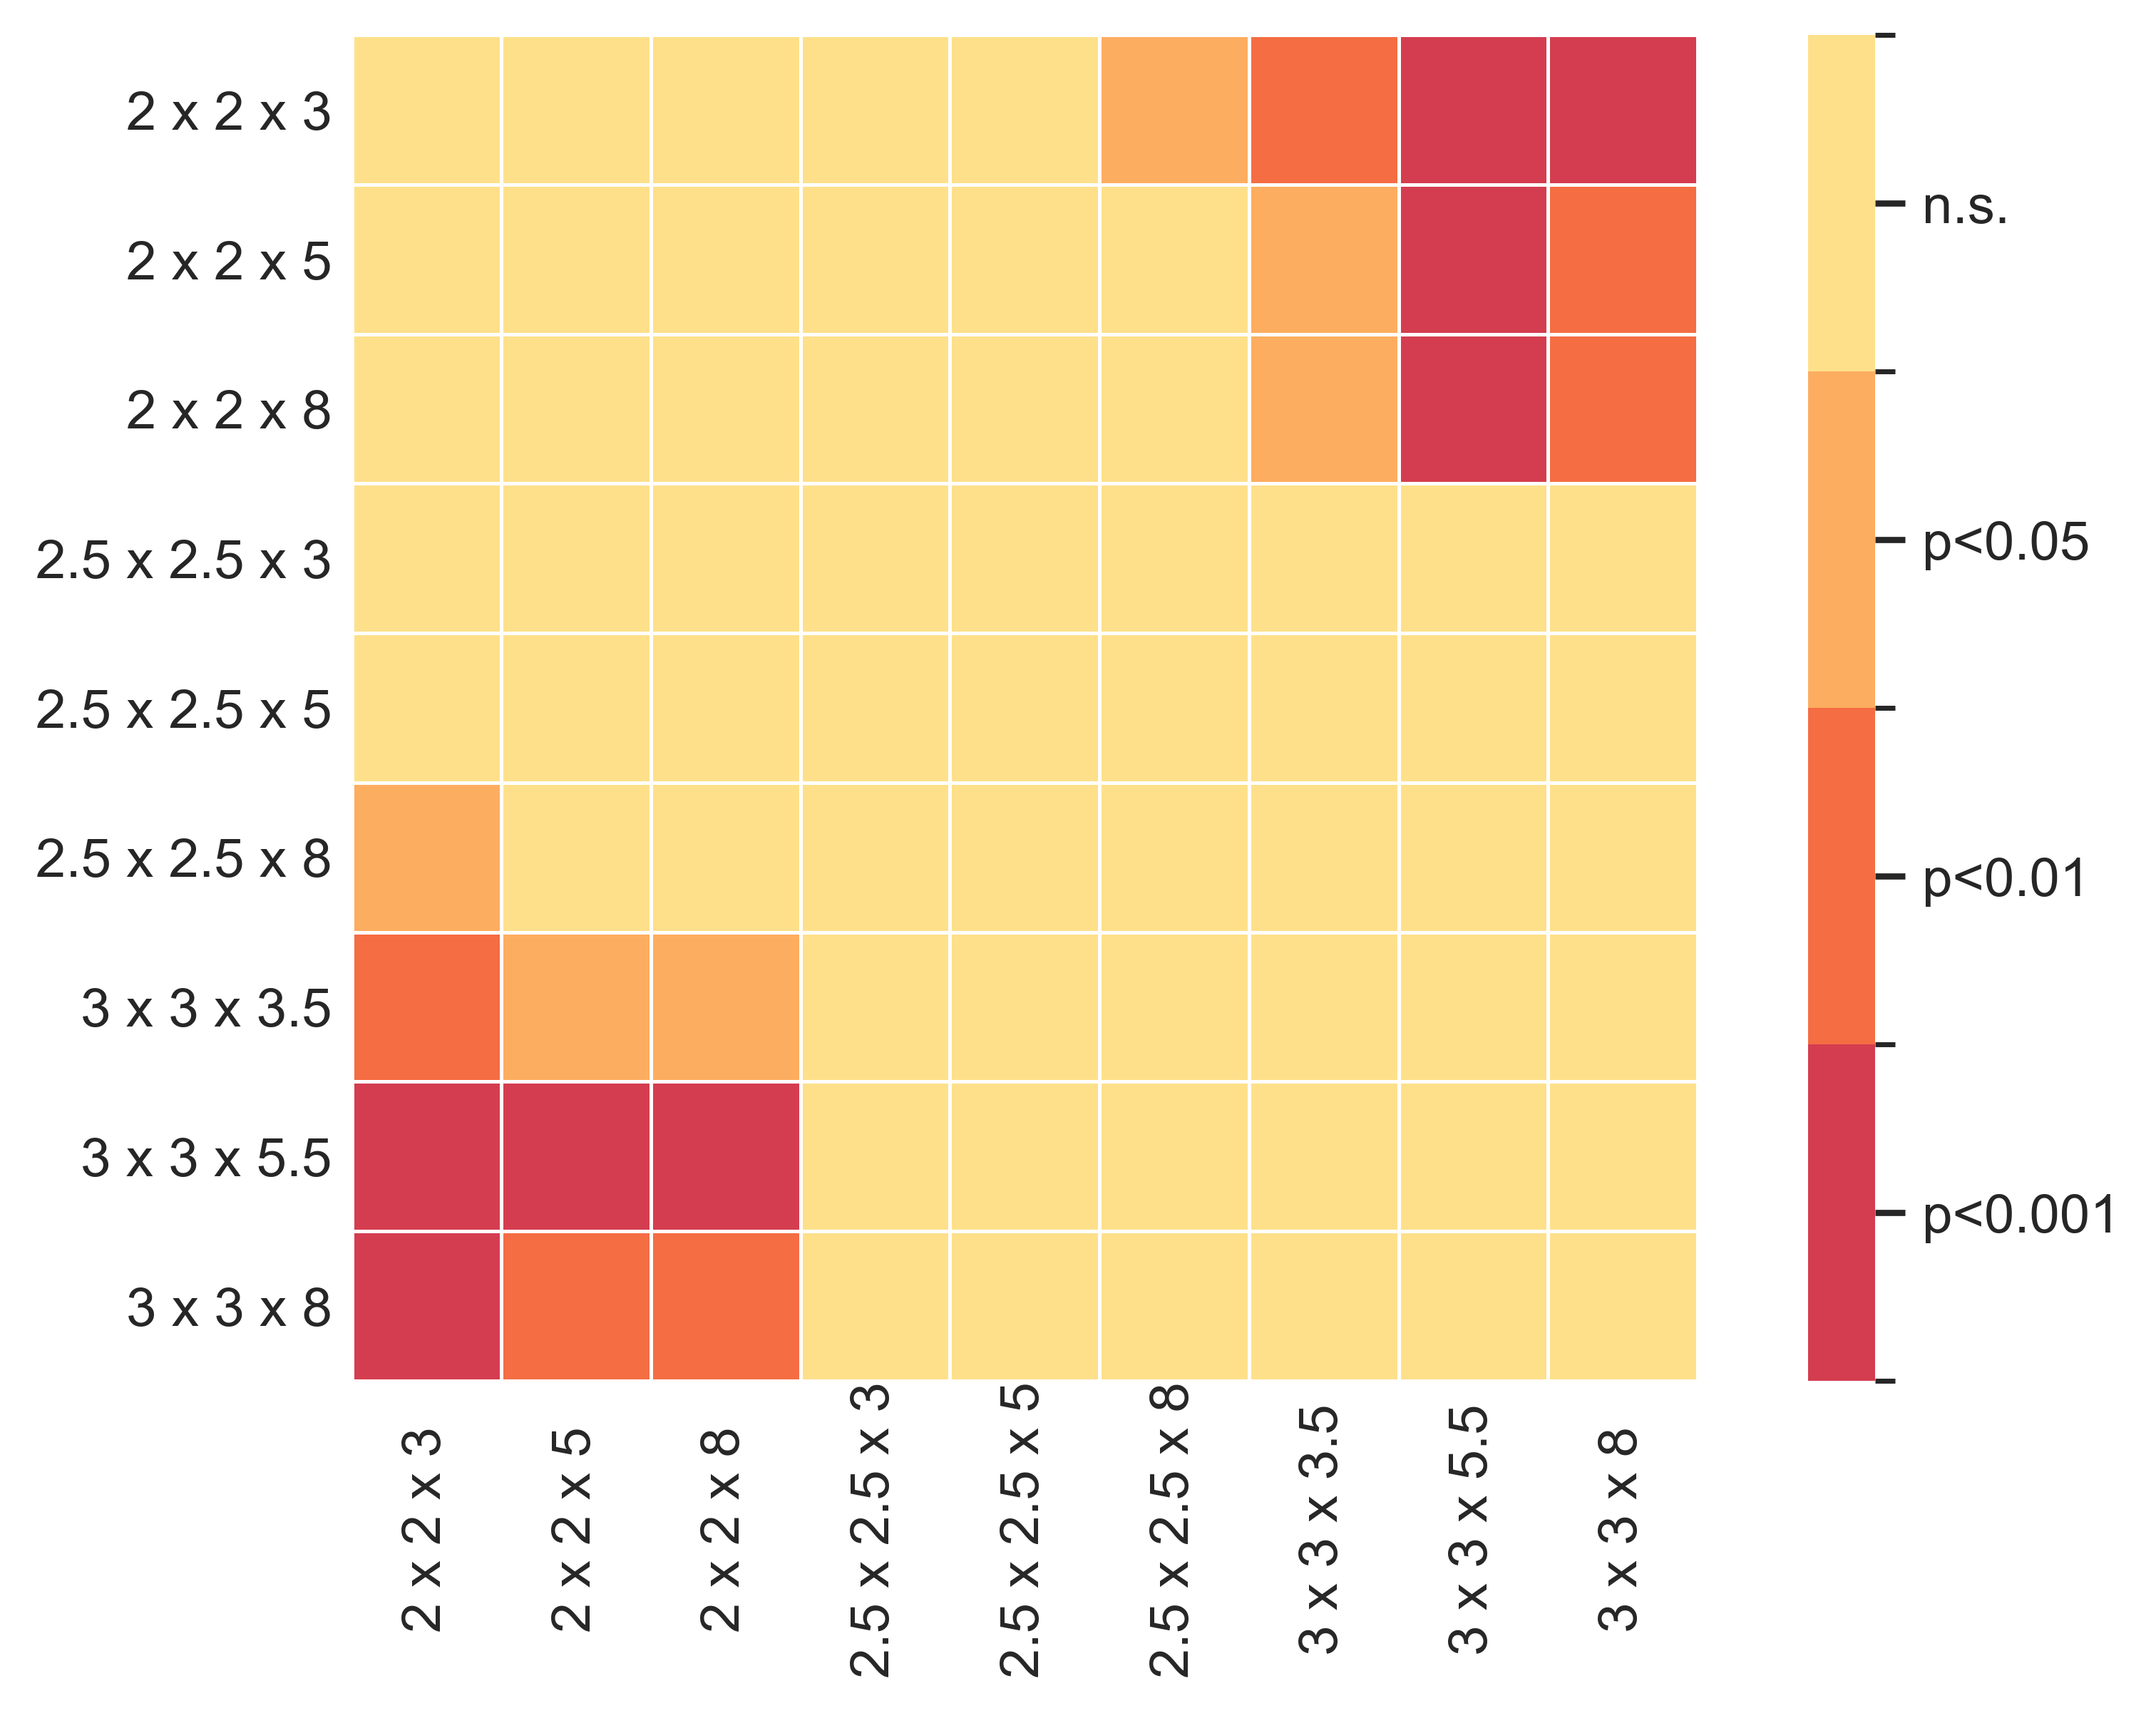

In [27]:
import seaborn as sns
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((9,9))
hypothesis[:] = np.nan


normal = 0
for ii in range(MD.shape[-1]):
    normal +=stats.shapiro(MD[:,ii])[0] >alpha #Normal is greater than alpha


if normal <MD.shape[-1]: # Non-normal distribution
    result = stats.friedmanchisquare(MD[:,0],MD[:,1],MD[:,2],MD[:,3],MD[:,4],MD[:,5],MD[:,6],MD[:,7],MD[:,8])
    if result[1] < alpha:
        test = sp.posthoc_wilcoxon(MD.T,p_adjust = 'holm-sidak')
        hypothesis = test
    else:
        hypothesis = np.nan

elif normal ==MD.shape[-1]: # normal distribution data 
    result = stats.f_oneway(MD[:,0],MD[:,1],MD[:,2],MD[:,3],MD[:,4],MD[:,5],MD[:,6],MD[:,7],MD[:,8])
    if result[1] < alpha:
        test = sp.posthoc_ttest(MD.T,p_adjust = 'holm-sidak')
        hypothesis = test 
    else:
        hypothesis = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import numpy as np

labels = ["2 x 2 x 3","2 x 2 x 5","2 x 2 x 8",
        "2.5 x 2.5 x 3","2.5 x 2.5 x 5","2.5 x 2.5 x 8",
        "3 x 3 x 3.5","3 x 3 x 5.5","3 x 3 x 8",
        ]


my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(1, 1, figsize=(8,5),sharex=True,sharey = True,dpi=500)
count = 2

mask =  np.tri(hypothesis.shape[0], k=-1)
mask[mask==0] = np.nan
A = hypothesis

ax = sns.heatmap(A,annot = False, linewidth=.5,
            norm=my_norm,cmap = my_cmap,cbar = True,annot_kws={"fontsize":8}, xticklabels=labels, yticklabels=labels,square = True)
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
ax.set_xticklabels(ax.get_xticklabels(),  ha="center", va="center", position=(0, 0))
ax.tick_params(axis='x', which='major', pad=24)  # Adjust the pad value as needed
ax.tick_params(axis='y', which='major', pad=-2)  # Adjust the pad value as needed


count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)


fig.savefig('mMD_figure_statistics.svg', format='svg', bbox_inches='tight')

# Report Median as a Heatmap
Here we report the medians that are visualized in the boxplot as a Heatmap. The bolded value is the global median while the 95% confidence interval is in brackets

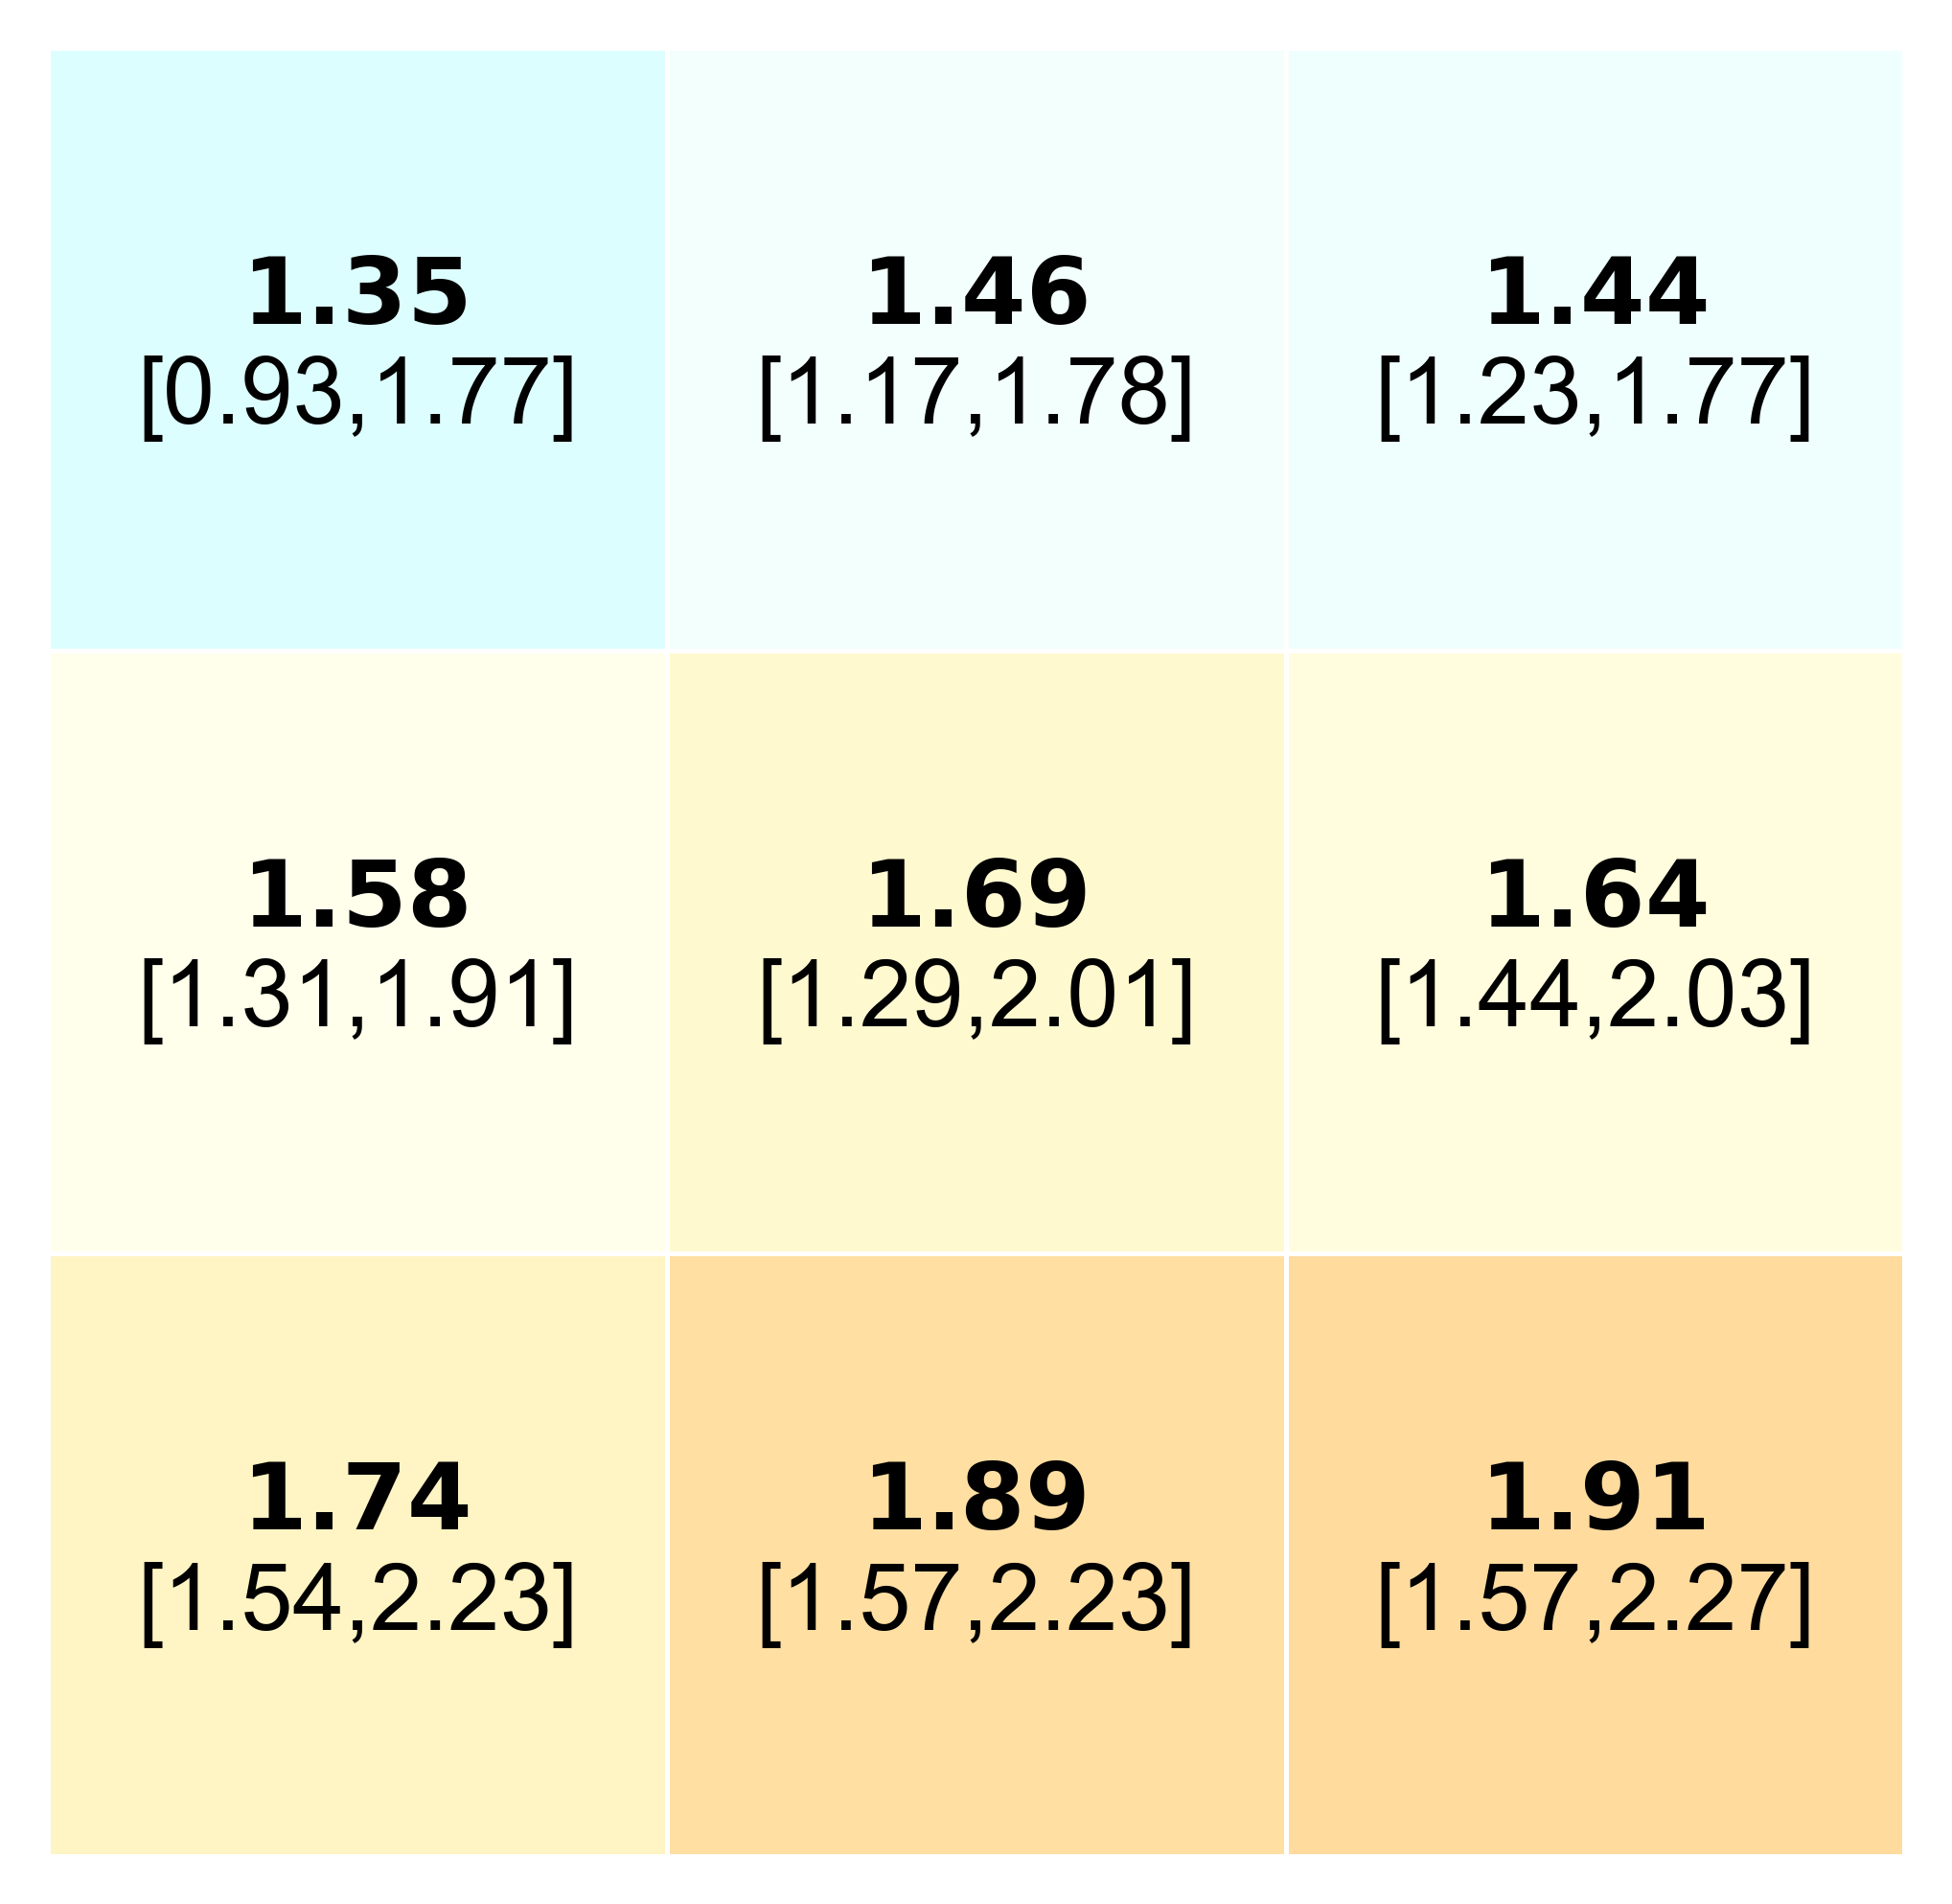

In [28]:
median_MD = np.nanmedian(MD,axis = 0)

median_MD_map = [median_MD[:3],median_MD[3:6],median_MD[6:]]


text = np.array(labels)
formatted_text = (np.asarray([" $\\mathbf{{ {:.2f} }}$  \n[{:.2f},{:.2f}]".format( 
    data, lower,upper) for  data, lower,upper in zip(np.array(median_MD).flatten(), np.array(lb).flatten(),np.array(ub).flatten(),)]) ).reshape(3, 3) 


fig, axes = plt.subplots(1, 1, figsize=(5,5),sharex=True,sharey = True,dpi=500)
ax = sns.heatmap(median_MD_map,annot=formatted_text,linewidth=.5,fmt="",annot_kws={"fontsize":14,"color":'black'},
            cmap = cDTI_cmaps['MD'],cbar = False,vmin = 0,vmax = 3)

axes.set_yticklabels(['', '', ''],size = 0,color='white')
axes.set_xticklabels(['', '', ''],size = 0,color='white')

fig.savefig('mMD_figure_heatmap.svg', format='svg', bbox_inches='tight')



# AHA Segments

In [29]:
segment_mean= []

for vv in range(11):
    vol_list = []
    for ii in range(9):
        main_path = os.path.join(os.path.abspath('../../Data/NifTi/'+vol_idx[vv]) + '/'+ vox_folder[ii] + '/ADC_Filtered')
        path_segmentation = os.path.join(os.path.abspath('../../Data/Segmentations/'+vol_idx[vv]),vox_folder[ii])
        path_maps  = os.path.join(os.path.abspath('../../Data/DTI_Maps/'+vol_idx[vv])+'/'+ vox_folder[ii] + '/ADC_Filtered')

        Seg_path    = os.path.join(path_segmentation)
        Maps_Folder = os.path.join(path_maps)

        myo_mask = loadmat(os.path.join(Seg_path,'AHA_mask.mat'))['AHA']
        myo_mask = myo_mask.astype('float')
        myo_mask[myo_mask == 0] = np.nan

        Standard_DTI_Metrics = loadmat(os.path.join(Maps_Folder, 'Standard_DTI_Metrics.mat'))
        data = Standard_DTI_Metrics['MD']

        aha = []

        labels = np.unique(myo_mask)
        for label in labels:
            if label != np.nan:
                roi_data = np.zeros_like(data)
                roi_data[myo_mask == label] = data[myo_mask == label]
                roi_data[roi_data ==0] = np.nan

                aha.append(np.nanmean(roi_data))

        vol_list.append(aha)
    
    segment_mean.append(vol_list)

segment_avg_array = np.array(segment_mean)
segment_group_med = np.nanmedian(segment_avg_array,axis = 0)

<ipython-input-29-b5d2e76fc1cd>:29: RuntimeWarning: Mean of empty slice
  aha.append(np.nanmean(roi_data))
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [30]:
med_MD.shape

(9,)

In [31]:
import seaborn as sns

# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
from statsmodels.stats.multitest import multipletests

seg_pvalue = []
seg_idx = []
for vox in range(9):
    alpha= 0.05
    
    hypothesis = []

    for aha in range(6):
        normal = 0
        MD = segment_avg_array[:,vox,aha]
        med = [med_MD[vox]]*11
        normal =stats.shapiro(MD)[0] >alpha #Normal is greater than alpha
        

        if normal == 1: # Non-normal distribution
            result = stats.wilcoxon(MD,med)
            

        elif normal < 1: # normal distribution data 
            result = stats.ttest_rel(MD,med)

        hypothesis.append(result.pvalue)
        #print( med_MD[vox], np.round(result.pvalue,3),MD)
    reject, hypothesis_corrected, _, _ = multipletests(hypothesis, alpha=alpha, method='holm-sidak')
    
    seg_pvalue.append(hypothesis_corrected)
    significant_indices = [idx+7 for idx, p in enumerate(hypothesis_corrected) if p < 0.05]
    print('Hypthesis results for voxel:',vox_folder[vox],  hypothesis_corrected,significant_indices)
    seg_idx.append(significant_indices)
    #print(np.round(hypothesis,2),significant_indices, segment_group_med[vox,:-1])


print(seg_idx)

Hypthesis results for voxel: vol_2.0res_3.0sl [0.70019531 0.01744988 0.01744988 0.62413365 0.07217852 0.62413365] [8, 9]
Hypthesis results for voxel: vol_2.0res_5.0sl [0.71360779 0.05718173 0.08939396 0.71360779 0.08939396 0.62413365] []
Hypthesis results for voxel: vol_2.0res_8.0sl [0.27479029 0.01166168 0.04788372 0.82119656 0.15768176 0.82119656] [8, 9]
Hypthesis results for voxel: vol_2.5res_3.0sl [0.18883306 0.01166168 0.05357617 0.65553188 0.03371557 0.65553188] [8, 11]
Hypthesis results for voxel: vol_2.5res_5.0sl [0.6860013  0.22693804 0.22693804 0.6860013  0.53631077 0.6860013 ] []
Hypthesis results for voxel: vol_2.5res_8.0sl [0.79782682 0.47172854 0.01166168 0.79782682 0.19305255 0.79782682] [9]
Hypthesis results for voxel: vol_3.0res_3.5sl [0.96582031 0.02894157 0.19305255 0.71360779 0.19305255 0.27479029] [8]
Hypthesis results for voxel: vol_3.0res_5.5sl [0.76914978 0.04032103 0.06651555 1.         0.29292979 0.29292979] [8]
Hypthesis results for voxel: vol_3.0res_8.0sl [0

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [32]:
import matplotlib as mpl
def bullseye_plot(ax, data, seg_bold=None, cmap="viridis", norm=None):
    """
    Bullseye representation for the left ventricle. This is adapted from: https://matplotlib.org/stable/gallery/specialty_plots/leftventricle_bullseye.html
    Bullseye Plot will only show the mid-ventricular segments  only
    Parameters
    ----------
    ax : axes
    data : list[float]
        The intensity values for each of the 17 segments.
    seg_bold : list[int], optional
        A list with the segments to highlight.
    cmap : colormap, default: "viridis"
        Colormap for the data.
    norm : Normalize or None, optional
        Normalizer for the data.

    Notes
    -----
    This function creates the 17 segment model for the left ventricle according
    to the American Heart Association (AHA) [1]_

    References
    ----------
    .. [1] M. D. Cerqueira, N. J. Weissman, V. Dilsizian, A. K. Jacobs,
        S. Kaul, W. K. Laskey, D. J. Pennell, J. A. Rumberger, T. Ryan,
        and M. S. Verani, "Standardized myocardial segmentation and
        nomenclature for tomographic imaging of the heart",
        Circulation, vol. 105, no. 4, pp. 539-542, 2002.
    """

    data = np.ravel(data)
    if seg_bold is None:
        seg_bold = []
    if norm is None:
        norm = mpl.colors.Normalize(vmin=data.min(), vmax=data.max())
    
    r = np.linspace(0.2, 1, 4)
    ax.set(ylim=[0, 1], xticklabels=[], yticklabels=[])
    ax.grid(False)  # Remove grid
    # Fill segments 1-6, 7-12, 13-16.
    for start, stop, r_in, r_out in [
            
            (6, 12, r[1], r[2]),
            
    ]:
        n = stop - start
        dtheta = 2*np.pi / n
        ax.bar(np.arange(n) * dtheta + np.pi/2, r_out - r_in, dtheta, r_in,
               color=cmap(norm(data[start:stop])))


        count = 0
        rotation = [0,60, -60,0,60,-60]
        position = [0.58,0.58,0.61,0.58,0.58,0.56]
        # Add labels to each segment
        for i in range(start, stop):
            theta_i = i * dtheta + (np.pi/6 + np.pi/2)/2
            theta_i_plus_one = (i + 1) * dtheta + (np.pi/6 + np.pi/2)/2
            theta_center = (theta_i + theta_i_plus_one) / 2
            r_center = (r_in + r_out) / 2


            #ax.text(theta_center, r_center, str(i + 1), ha='center', va='center')
            label = np.round(data[i],2)
            ax.text(theta_center, position[count], label, ha='center', va='center',rotation = rotation[count],size = 12)
            count +=1


    # Now, draw the segment borders.  In order for the outer bold borders not
    # to be covered by inner segments, the borders are all drawn separately
    # after the segments have all been filled.  We also disable clipping, which
    # would otherwise affect the outermost segment edges.
    # Draw edges of segments 1-6, 7-12, 13-16.
    for start, stop, r_in, r_out in [
            (6, 12, r[1], r[2]),
    ]:
        n = stop - start
        dtheta = 2*np.pi / n
        ax.bar(np.arange(n) * dtheta + np.pi/2, r_out - r_in, dtheta, r_in,
               clip_on=False, color="none", edgecolor="k", linewidth=[
                   4 if i + 1 in seg_bold else 2 for i in range(start, stop)])
    




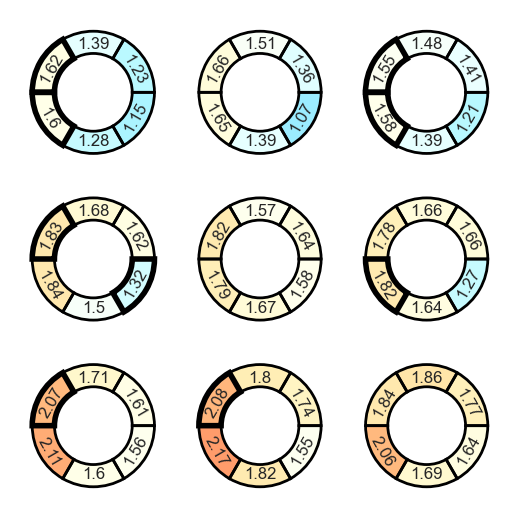

In [33]:
sns.set_style("white") 
sns.set_style(style=None, rc=None) 
fig = plt.figure(figsize=(5, 5), layout="constrained",dpi=100)
fig.get_layout_engine().set(wspace=-5, w_pad=-5, hspace=-5, h_pad=-5)
axs = fig.subplots(3, 3, subplot_kw=dict(projection='polar'))
cmap =cDTI_cmaps['MD']
norm = mpl.colors.Normalize(vmin=0, vmax=3)
# Create an empty ScalarMappable to set the colorbar's colormap and norm.
# The following gives a basic continuous colorbar with ticks and labels.

count = 0
for ii in range(3):
    for jj in range(3):
        plot_values = np.concatenate(([np.nan]*6,segment_group_med[count,:]))
        bold = seg_idx[count]
        
        #plot_values = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,0.5,1,1.5,2,2.5,3,3.5]
        bullseye_plot(axs[ii,jj], plot_values, cmap=cmap, norm=norm,seg_bold = bold,)
        count +=1
        axs[ii,jj].spines['polar'].set_visible(False)
        

fig.savefig('mMD_figure_aha_segments.svg', format='svg', bbox_inches='tight')



# Figure Label

In [34]:
import matplotlib as mpl
def bullseye_plot(ax, data, seg_bold=None, cmap="viridis", norm=None):
    """
    Bullseye representation for the left ventricle. This is adapted from: https://matplotlib.org/stable/gallery/specialty_plots/leftventricle_bullseye.html
    Bullseye Plot will only show the mid-ventricular segments  only
    Parameters
    ----------
    ax : axes
    data : list[float]
        The intensity values for each of the 17 segments.
    seg_bold : list[int], optional
        A list with the segments to highlight.
    cmap : colormap, default: "viridis"
        Colormap for the data.
    norm : Normalize or None, optional
        Normalizer for the data.

    Notes
    -----
    This function creates the 17 segment model for the left ventricle according
    to the American Heart Association (AHA) [1]_

    References
    ----------
    .. [1] M. D. Cerqueira, N. J. Weissman, V. Dilsizian, A. K. Jacobs,
        S. Kaul, W. K. Laskey, D. J. Pennell, J. A. Rumberger, T. Ryan,
        and M. S. Verani, "Standardized myocardial segmentation and
        nomenclature for tomographic imaging of the heart",
        Circulation, vol. 105, no. 4, pp. 539-542, 2002.
    """

    data = np.ravel(data)
    if seg_bold is None:
        seg_bold = []
    if norm is None:
        norm = mpl.colors.Normalize(vmin=data.min(), vmax=data.max())
    
    r = np.linspace(0.2, 1, 4)
    ax.set(ylim=[0, 1], xticklabels=[], yticklabels=[])
    ax.grid(False)  # Remove grid
    # Fill segments 1-6, 7-12, 13-16.
    for start, stop, r_in, r_out in [
            
            (6, 12, r[1], r[2]),
            
    ]:
        n = stop - start
        dtheta = 2*np.pi / n
        ax.bar(np.arange(n) * dtheta + np.pi/2, r_out - r_in, dtheta, r_in,
               color=cmap(norm(data[start:stop])))


        count = 0
        rotation = [0,60, -60,0,60,-60]
        position = [0.58,0.58,0.61,0.58,0.58,0.56]
        # Add labels to each segment
        for i in range(start, stop):
            theta_i = i * dtheta + (np.pi/6 + np.pi/2)/2
            theta_i_plus_one = (i + 1) * dtheta + (np.pi/6 + np.pi/2)/2
            theta_center = (theta_i + theta_i_plus_one) / 2
            r_center = (r_in + r_out) / 2


            #ax.text(theta_center, r_center, str(i + 1), ha='center', va='center')
           # ax.text(theta_center, position[count], label, ha='center', va='center',rotation = rotation[count],size = 12)
            ax.text(theta_center, position[count], str(i + 1), rotation = rotation[count], ha='center', va='center',color='white',size =38)
            count +=1


    # Now, draw the segment borders.  In order for the outer bold borders not
    # to be covered by inner segments, the borders are all drawn separately
    # after the segments have all been filled.  We also disable clipping, which
    # would otherwise affect the outermost segment edges.
    # Draw edges of segments 1-6, 7-12, 13-16.
    for start, stop, r_in, r_out in [
            (6, 12, r[1], r[2]),
    ]:
        n = stop - start
        dtheta = 2*np.pi / n
        ax.bar(np.arange(n) * dtheta + np.pi/2, r_out - r_in, dtheta, r_in,
               clip_on=False, color="none", edgecolor="k", linewidth=[
                   4 if i + 1 in seg_bold else 2 for i in range(start, stop)])
    


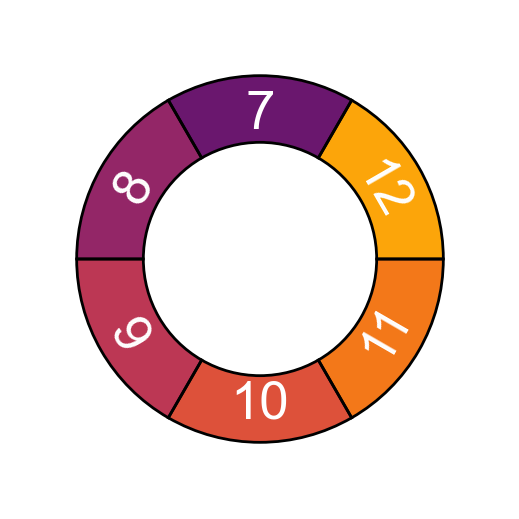

In [35]:
sns.set_style("white") 
sns.set_style(style=None, rc=None) 
fig = plt.figure(figsize=(5, 5), layout="constrained",dpi=100)
fig.get_layout_engine().set(wspace=-5, w_pad=-5, hspace=-5, h_pad=-5)
axs = fig.subplots(1,1, subplot_kw=dict(projection='polar'))
cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=-1, vmax=4)
# Create an empty ScalarMappable to set the colorbar's colormap and norm.
# The following gives a basic continuous colorbar with ticks and labels.

#plot_values = np.concatenate(([np.nan]*6,segment_group_med[count,:]))
plot_values = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,0.5,1,1.5,2,2.5,3,3.5]
bullseye_plot(axs, plot_values, cmap=cmap, norm=norm)
count +=1
axs.spines['polar'].set_visible(False)


fig.savefig('aha_segments.svg', format='svg', bbox_inches='tight')

